# Final Data Mining Proyect

### Victor Ortiz
### Luis Fernando Monterrubio Cota

In [84]:
import re
from collections import defaultdict
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import networkx as nx
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords

Let´s start reading the scripts!

We first read the contents of the scripts for episodes 1 and 7 of "Suits" to understand their structure. This involved opening and concatenating the text files to create a single string for analysis.

In [85]:

# First, we open and read the contents of the uploaded files to understand their structure and content.
# Specifying the file paths for the two script files: "Suits_1x07.txt" and "Suits_1x01_-_Pilot.txt".
file = 'Suits_1x07.txt'
file_2 = 'Suits_1x01_-_Pilot.txt'

# Opening and reading the content of the first file.
with open(file, 'r', encoding='utf-8') as file:
    content_1 = file.read()

# Opening and reading the content of the second file.
with open(file_2, 'r', encoding='utf-8') as file:
    content_2 = file.read()

# Combining the contents of both files into a single variable, separated by two new lines for clarity.
content = content_1 + "\n\n" + content_2

# Printing the first 400 characters of the combined content to get an overview of the scripts.
print(content[:300])



Executive Producer: David Bartis Episode %*107

Executive Producer: Doug Liman Production %01007
Executive Producer: Sean Jablonski
Co-Executive Producer: Aaron Korsh
Co-Executive Producer: Jon Cowan
Producer: Gene Klein

Supervising Producer: Kevin Bray
Producer: Steve Wakefield
Director: Tim Mathe


We then parsed this combined script to extract dialogues associated with each character. This was done using regular expressions to identify character names (which are typically in uppercase in scripts) and capturing the subsequent dialogue lines until the next character's dialogue begins. The summary data was then converted into a Pandas DataFrame for better visualization and analysis. This DataFrame was sorted in descending order of dialogue count, enabling us to easily identify which characters had the most lines in the scripts.

In [86]:
# Extracting dialogues and characters from the script
from collections import defaultdict
import re
import pandas as pd

# Initializing a defaultdict to store dialogues, keyed by character names
dialogues = defaultdict(list)

# Compiling a regular expression to identify character names in the script.
# This pattern matches strings that are all uppercase (character names), potentially followed by stage directions in parentheses
character_pattern = re.compile(r'^([A-Z][A-Z ]+)(?:\s+\(.*\))?$', re.MULTILINE)

# Splitting the combined script content into individual lines
lines = content.split('\n')

# Parsing each line of the script
for i, line in enumerate(lines):
    # Checking if the line matches the character name pattern
    if character_pattern.match(line):
        character = line.strip()
        dialogue = []
        # Collecting dialogue lines following the character name until another character name or blank line is encountered
        for j in range(i+1, len(lines)):
            dialogue_line = lines[j].strip()
            if dialogue_line == '' or character_pattern.match(dialogue_line):
                break
            dialogue.append(dialogue_line)
        # Adding the collected dialogue lines to the corresponding character in the dialogues dictionary
        if dialogue:
            dialogues[character].append(' '.join(dialogue))

# Creating a summary dictionary that counts the number of dialogue blocks for each character
dialogue_summary = {character: len(dialogues[character]) for character in dialogues}

# Converting the summary dictionary to a DataFrame for better visualization
dialogue_df = pd.DataFrame(list(dialogue_summary.items()), columns=['Character', 'Dialogue_Count'])

# Sorting the DataFrame in descending order based on the count of dialogue blocks
dialogue_df_sorted = dialogue_df.sort_values(by='Dialogue_Count', ascending=False)

# Displaying the top 10 characters with the highest dialogue counts
dialogue_df_sorted.head(10)



,Character,Dialogue_Count
9,MIKE,355
13,HARVEY,301
8,RACHEL,71
40,KATHERINE,58
33,JENNY,55
27,SCOTTIE,50
22,KYLE,45
20,LOUIS,35
17,DONNA,31
42,TREVOR,27


Defining the clean_dialogues Function: This function is intended to clean the dialogues in several ways:

* Remove Non-Alphanumeric Characters: It uses a regular expression to find and remove characters that are not letters, numbers, or spaces. This step cleans up any special characters or punctuation.
* Remove Dates: Another regular expression is used to identify and remove date formats from the dialogues, as dates are not usually relevant for text analysis in this context.
* Remove Stopwords: The function splits each dialogue into words and removes any words that are in the list of stopwords. This is to focus the analysis on more significant words.

Cleaning Process: The function iterates over each character's dialogues in the dialogues dictionary. For each dialogue, it performs the cleaning steps mentioned above and then recombines the cleaned words back into sentences. These cleaned dialogues are stored in a new dictionary called cleaned_dialogues.

In [87]:
nltk.download('stopwords')

# Function to clean dialogues
def clean_dialogues(dialogues):
    # Preparing a set of stopwords
    stop_words = set(stopwords.words('english'))

    # Pattern to identify and remove non-alphanumeric characters (excluding spaces)
    non_alpha_numeric_pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Pattern to identify and remove dates (simple pattern for common date formats)
    date_pattern = re.compile(r'\b(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{2,4}[-/]\d{1,2}[-/]\d{1,2})\b')

    cleaned_dialogues = defaultdict(list)

    for character, dialogue_list in dialogues.items():
        for dialogue in dialogue_list:
            # Removing non-alphanumeric characters
            dialogue = non_alpha_numeric_pattern.sub('', dialogue)

            # Removing dates
            dialogue = date_pattern.sub('', dialogue)

            # Removing stopwords
            dialogue_words = dialogue.split()
            cleaned_words = [word for word in dialogue_words if word.lower() not in stop_words]
            cleaned_dialogue = ' '.join(cleaned_words)

            cleaned_dialogues[character].append(cleaned_dialogue)

    return cleaned_dialogues

# Cleaning the dialogues
dialogues = clean_dialogues(dialogues)

# Displaying some cleaned dialogues for review
for character, dialogue_list in list(dialogues.items())[:10]:
    print(f"{character}: {dialogue_list[:2]}")



SUTTS: ['107']
LIBRARY: ['KYLE CUBICLE']
CONFERENCE ROOM: ['DONNAS DESK']
WATER COOLER AREA: ['LOUIS OFFICE']
OFFICE TOWER OFFICE TOWER: ['LOBBY JENNYS APARTMENT ELEVATOR VEGAS HOTEL DEBEQUE HOTEL']
SUITE: ['JENNYS APARTMENT HARVEY APARTMENT']
MIDTOWN BAR: ['SUITS 107 Play Man Final Shooting Script 72711']
TEASER: ['1 EXT OFFICE TOWER DAY 1']
RACHEL: ['Watch', 'easier ways kill']
MIKE: ['Imso sorry okay', 'Rachel']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
# Contando las interacciones entre personajes
interactions = defaultdict(int)

# Limpiamos los nombres de los personajes para unificarlos (eliminando "(CONT'D)" y otros añadidos)
cleaned_dialogues = defaultdict(list)
for character, dialogue in dialogues.items():
    clean_character = character.split(" (")[0]
    cleaned_dialogues[clean_character].extend(dialogue)

# Contando las interacciones
prev_character = None
for line in lines:
    line = line.strip()
    if character_pattern.match(line):
        character = line.split(" (")[0]
        if prev_character and character != prev_character:
            # Contamos la interacción entre prev_character y character
            interaction_pair = tuple(sorted([prev_character, character]))
            interactions[interaction_pair] += 1
        prev_character = character

# Resumen de las interacciones
sorted_interactions = sorted(interactions.items(), key=lambda x: x[1], reverse=True)
sorted_interactions= sorted_interactions[:30]  # Mostrando la  s primeras 10 interacciones más frecuentes

sorted_interactions

[(('HARVEY', 'MIKE'), 232),
 (('MIKE', 'RACHEL'), 127),
 (('HARVEY', 'SCOTTIE'), 98),
 (('JENNY', 'MIKE'), 76),
 (('HARVEY', 'KATHERINE'), 75),
 (('KYLE', 'MIKE'), 48),
 (('MIKE', 'TREVOR'), 42),
 (('DONNA', 'MIKE'), 28),
 (('MIKE', 'NANCY'), 25),
 (('DONNA', 'HARVEY'), 24),
 (('KATHERINE', 'PHILLIP'), 23),
 (('JESSICA', 'MIKE'), 22),
 (('HARVEY', 'LOUIS'), 21),
 (('GERALD', 'HARVEY'), 19),
 (('LOUIS', 'MIKE'), 17),
 (('JESSICA', 'KYLE'), 17),
 (('HARVEY', 'JONES'), 16),
 (('DOCKERY', 'HARVEY'), 16),
 (('JENNY', 'KYLE'), 13),
 (('DEFENSE COUNSEL', 'JOANNA'), 13),
 (('HARVEY', 'JOANNA'), 12),
 (('GRAMMY', 'MIKE'), 11),
 (('JOANNA', 'MIKE'), 11),
 (('HARVEY', 'VANESSA'), 10),
 (('DEFENSE COUNSEL', 'HARVEY'), 10),
 (('HARVEY', 'JUDGE'), 10),
 (('HARVEY', 'WAITRESS'), 8),
 (('HARVEY', 'WORKER'), 8),
 (('GARY', 'LOUIS'), 8),
 (('MIKE', 'YOUNG MAN'), 7)]

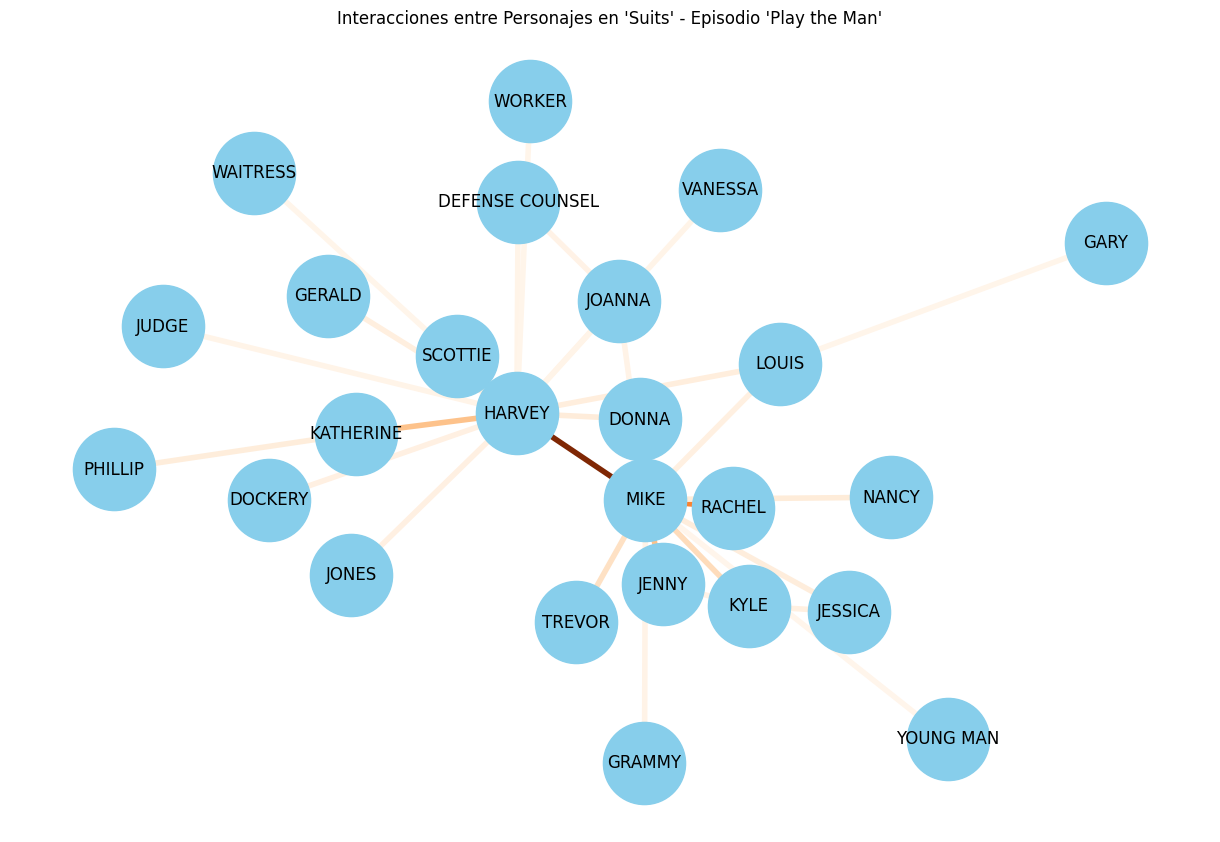

In [89]:
# Creando un grafo a partir de las interacciones
G = nx.Graph()
for (char1, char2), count in sorted_interactions:
    G.add_edge(char1, char2, weight=count)

# Dibujando el grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Para la consistencia del layout
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3500, edge_color=weights, width=4, edge_cmap=plt.cm.Oranges)
plt.title("Interacciones entre Personajes en 'Suits' - Episodio 'Play the Man'")
plt.show()

In [90]:
# Initializing NLTK's Sentiment Intensity Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to get dialogues for a pair of characters
def get_dialogues_for_pair(character1, character2, lines, character_pattern):
    dialogues = []
    current_character = None
    for line in lines:
        if character_pattern.match(line):
            current_character = line.split(" (")[0]
        elif current_character in [character1, character2]:
            dialogues.append(line.strip())
    return dialogues

# Function to analyze sentiment of dialogues
def analyze_sentiment(dialogues):
    sentiment_scores = [sia.polarity_scores(dialogue)["compound"] for dialogue in dialogues if dialogue]
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Analyzing sentiment for each interaction pair and including the number of interactions
sentiment_summary_with_interactions = {}

for pair, interaction_count in sorted_interactions:
    characters = pair
    dialogues = get_dialogues_for_pair(characters[0], characters[1], lines, character_pattern)
    sentiment_score = analyze_sentiment(dialogues)
    sentiment_summary_with_interactions[characters] = (interaction_count, sentiment_score)

# Displaying the sentiment analysis along with the number of interactions for each pair
for pair, (count, sentiment) in sentiment_summary_with_interactions.items():
    print(f"{pair}: Interactions: {count}, Sentiment Score: {sentiment}")



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


('HARVEY', 'MIKE'): Interactions: 232, Sentiment Score: 0.03186339897260274
('MIKE', 'RACHEL'): Interactions: 127, Sentiment Score: 0.028492782789729356
('HARVEY', 'SCOTTIE'): Interactions: 98, Sentiment Score: 0.03186109445277361
('JENNY', 'MIKE'): Interactions: 76, Sentiment Score: 0.03531878287002254
('HARVEY', 'KATHERINE'): Interactions: 75, Sentiment Score: 0.034538237490664675
('KYLE', 'MIKE'): Interactions: 48, Sentiment Score: 0.028961028315946352
('MIKE', 'TREVOR'): Interactions: 42, Sentiment Score: 0.03175113904163394
('DONNA', 'MIKE'): Interactions: 28, Sentiment Score: 0.033449069247952344
('MIKE', 'NANCY'): Interactions: 25, Sentiment Score: 0.03005339805825243
('DONNA', 'HARVEY'): Interactions: 24, Sentiment Score: 0.036199402539208364
('KATHERINE', 'PHILLIP'): Interactions: 23, Sentiment Score: 0.04442146341463415
('JESSICA', 'MIKE'): Interactions: 22, Sentiment Score: 0.032735496183206106
('HARVEY', 'LOUIS'): Interactions: 21, Sentiment Score: 0.03884679040989946
('GER

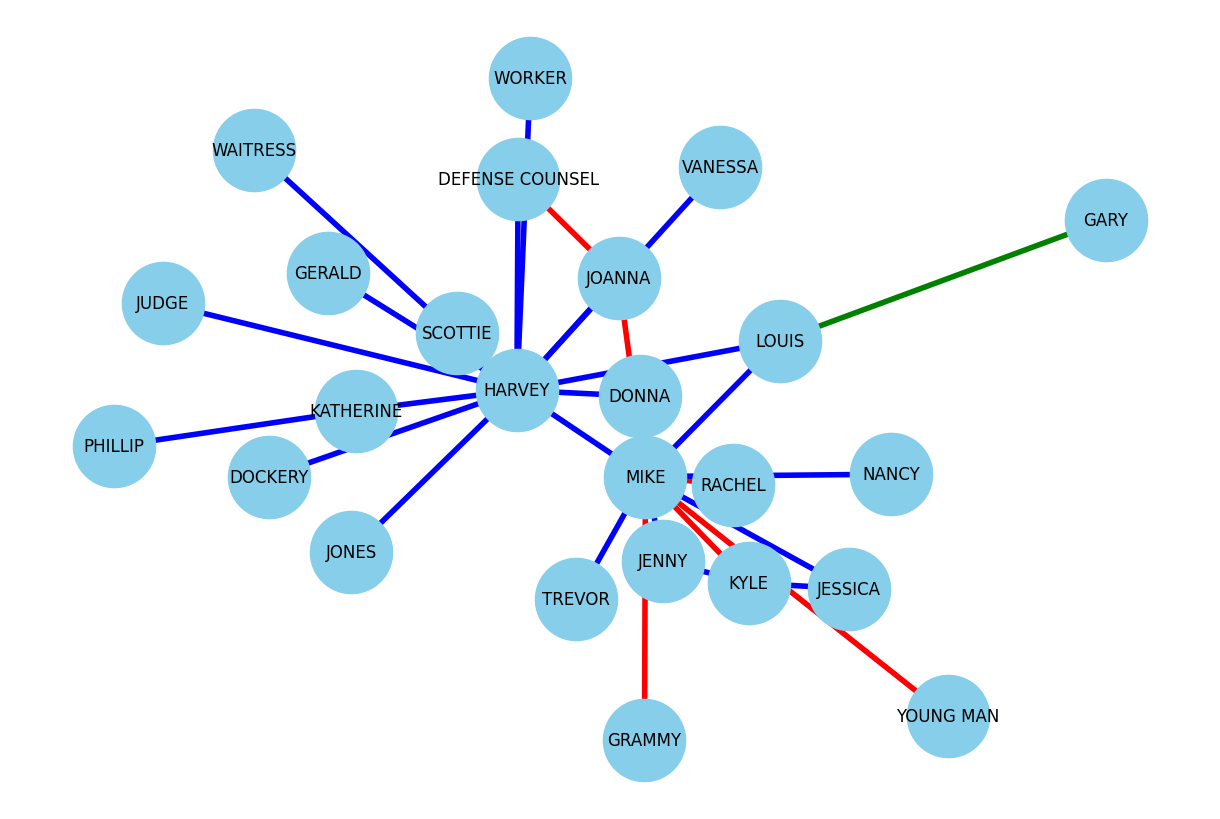

In [92]:
# Creando el grafo
G = nx.Graph()

# Añadiendo los nodos y aristas basados en las interacciones y análisis de sentimientos
for (character1, character2), (interaction_count, sentiment_score) in sentiment_summary_with_interactions.items():
    G.add_edge(character1, character2, weight=interaction_count)

    # Determinando el color de la arista basado en la puntuación de sentimiento
    if sentiment_score > 0.05:  # Suponiendo que un score > 0.05 es positivo
        color = 'green'
    elif sentiment_score < 0.03:  # Suponiendo que un score < -0.05 es negativo
        color = 'red'
    else:
        color = 'blue'  # Sentimientos neutrales o cercanos a cero

    # Asignando el color a la arista
    G[character1][character2]['color'] = color

# Dibujando el grafo
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, edge_color=colors, width=4, node_size=3500, node_color='skyblue')
plt.show()
